<a href="https://colab.research.google.com/github/Jason-Adam/msds-462/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning MSDS462 Module 9 Ezana 
The goal of this notebook is to utilize transfer learning. The ResNet50 model was used to train a small data set of snakes for classification.  

Sources:<br/>
https://www.practicaldeeplearning.ai/<br/>
https://github.com/PracticalDL/Practical-Deep-Learning-Book/blob/master/code/chapter-2/1-predict-class.ipynb <br/>
https://learning.oreilly.com/library/view/practical-deep-learning/9781492034858/ch02.html#cats_vs_dogs_-_transfer_learning_in_30<br/>

# Imports & Data Ingest

In [ ]:
# Install TF 2.0
!pip install tensorflow==2.0

In [32]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [33]:
# Verify TF 2.0 installed
!pip list | grep tensorflow

tensorflow                    2.0.0         
tensorflow-datasets           4.0.1         
tensorflow-estimator          2.0.1         
tensorflow-gcs-config         2.4.0         
tensorflow-hub                0.12.0        
tensorflow-metadata           0.30.0        
tensorflow-probability        0.12.1        


In [34]:
# Mount Gdrive where images stored
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# EDA

In [35]:
# Helper function for classification from chapter 2
def classify(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    model = tf.keras.applications.resnet50.ResNet50()
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    prediction = model.predict(img_preprocessed)
    print(decode_predictions(prediction, top=3)[0])

In [36]:
# Sample Images chapter 2 
horse_img_path = "/content/gdrive/My Drive/ColabNotebooks/MSDS462/Module9/Data/train/horses/horse01-0.png"
human_img_path = "/content/gdrive/My Drive/ColabNotebooks/MSDS462/Module9/Data/train/humans/human01-00.png"
horse_img = image.load_img(horse_img_path, target_size=(224, 224))
human_img = image.load_img(human_img_path, target_size=(224, 224))


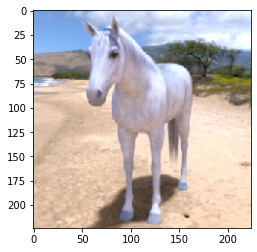

In [38]:
plt.imshow(horse_img)
plt.show()

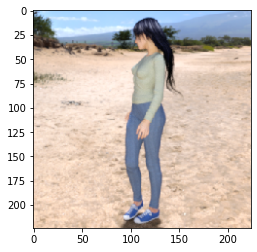

In [39]:
plt.imshow(human_img)
plt.show()

In [40]:
# Sample horse Prediction from chapter 2
classify(horse_img_path)

[('n02389026', 'sorrel', 0.7827731), ('n02422106', 'hartebeest', 0.099360906), ('n02109047', 'Great_Dane', 0.017728452)]


In [ ]:
# Sample human Prediction  from chapter 2
classify(human_img_path)

[('n09421951', 'sandbar', 0.32897818), ('n09428293', 'seashore', 0.07945829), ('n04357314', 'sunscreen', 0.05787471)]


# Modeling

In [43]:
# Setup variables and train and validation folders
TRAIN_DATA_DIR = "/content/gdrive/My Drive/ColabNotebooks/MSDS462/Module9/Data/train/"
VALIDATION_DATA_DIR = "/content/gdrive/My Drive/ColabNotebooks/MSDS462/Module9/Data/validation/"
TRAIN_SAMPLES = 52
VALIDATION_SAMPLES = 32
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 26

In [44]:
# Create image generators
train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)

val_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

#Shuffle during training
train_generator = train_datagen.flow_from_directory(
                        TRAIN_DATA_DIR,
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        seed=12355,
                        class_mode='categorical')

#No shuffling needed for validators                     
validation_generator = val_datagen.flow_from_directory(
                        VALIDATION_DATA_DIR,
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        class_mode='categorical')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [47]:
# Define Model ResNet50
def model_ResNet50_transfer():
    #Exclude the top layer and freeze the layers
    base_model = ResNet50(include_top=False, input_shape =(IMG_WIDTH,IMG_HEIGHT,3))
    for layer in base_model.layers[:]:
        layer.trainable = False # Freeze the layers
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [48]:
# Build and Train and fit the ResNet50 layered model without the top layer Model
model = model_ResNet50_transfer()
model.compile(loss='categorical_crossentropy',
              optimizer= tf.optimizers.Adam(lr=0.001),
              metrics=['acc'])

num_steps = math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE)   

model.fit_generator(train_generator,
                    steps_per_epoch = num_steps,
                    epochs=10,
                    validation_data = validation_generator,
                    validation_steps = num_steps)

Epoch 1/10
2/2 [==============================] - 54s 27s/step - loss: 0.5876 - acc: 0.7308 - val_loss: 0.6079 - val_acc: 0.7500
Epoch 2/10
2/2 [==============================] - 50s 25s/step - loss: 0.3072 - acc: 0.8269 - val_loss: 0.4160 - val_acc: 0.8654
Epoch 3/10
2/2 [==============================] - 50s 25s/step - loss: 0.3550 - acc: 0.8269 - val_loss: 0.0625 - val_acc: 0.9808
Epoch 4/10
2/2 [==============================] - 51s 25s/step - loss: 0.3326 - acc: 0.8269 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 5/10
2/2 [==============================] - 51s 25s/step - loss: 0.1238 - acc: 0.9231 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 6/10
2/2 [==============================] - 50s 25s/step - loss: 0.1090 - acc: 0.9808 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 7/10
2/2 [==============================] - 50s 25s/step - loss: 0.1297 - acc: 0.9615 - val_loss: 0.0219 - val_acc: 1.0000
Epoch 8/10
2/2 [==============================] - 51s 25s/step - loss: 0.0352 - acc: 0.9808 - val

# Results

In [49]:
# VARIABLES
VALIDATION_BATCH_SIZE = 16 

# DATA GENERATORS
validation_datagen = image.ImageDataGenerator(
        preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DATA_DIR,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=VALIDATION_BATCH_SIZE,
        shuffle=False,
        class_mode='categorical')
ground_truth = validation_generator.classes

fnames = validation_generator.filenames

Found 256 images belonging to 2 classes.


In [50]:
# Model predict generators 
predictions = model.predict_generator(validation_generator)

In [58]:
# display, plot helper functions
def display(sorted_indices, message):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        similar_image_paths.append(VALIDATION_DATA_DIR + fnames[name])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

# get sorted images with their probalities
def get_sorted_images_with_probabilities(
    prediction_table,
    get_highest_probability, 
    label, 
    number_of_items, 
    only_false_predictions=False
    ):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]

# plot images
def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)

In [59]:
# prediction_table is a dict with index, prediction, ground truth
prediction_table = {}
for index, val in enumerate(predictions):
    # get argmax index
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [value_of_highest_probability,
index_of_highest_probability, ground_truth[index]]
assert len(predictions) == len(ground_truth) == len(prediction_table)

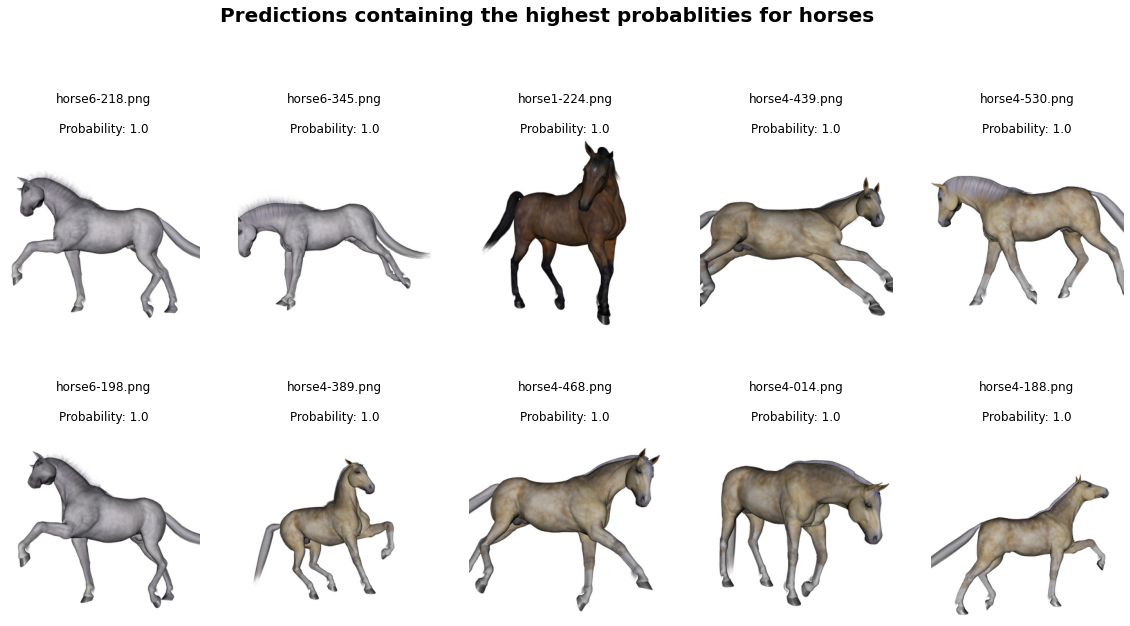

In [60]:
# Predictions containing the highest probablities for horses
indices = get_sorted_images_with_probabilities(prediction_table,
get_highest_probability=True, label=0, number_of_items=10,
only_false_predictions=False)
message = 'Predictions containing the highest probablities for horses'
display(indices[:10], message)

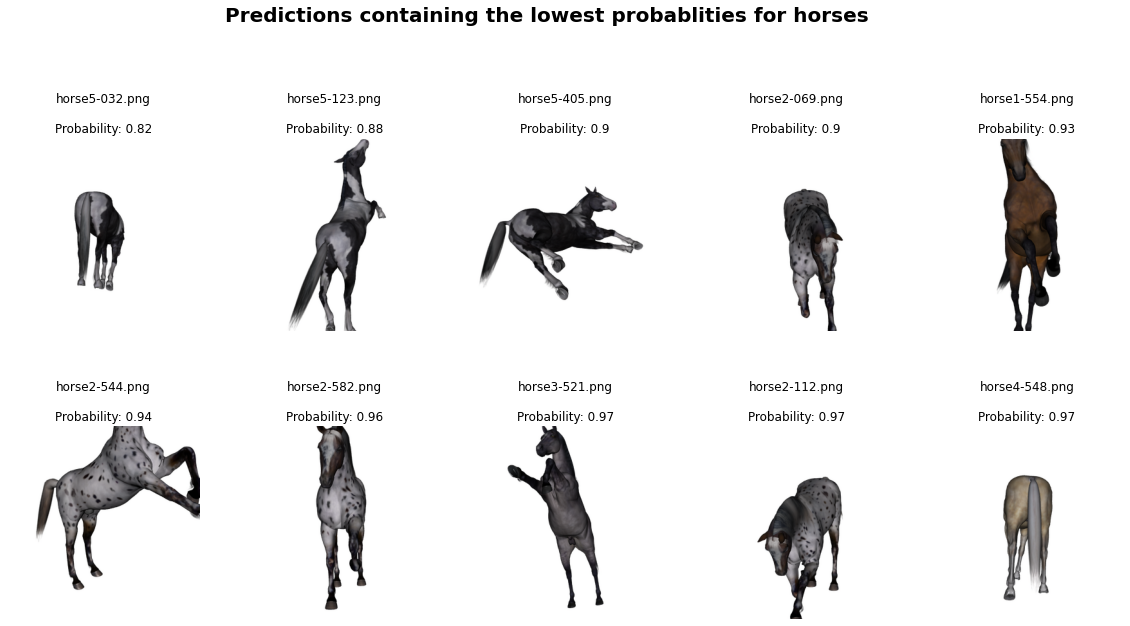

In [61]:
# Predictions containing the lowest probablities for horses
indices = get_sorted_images_with_probabilities(prediction_table,
get_highest_probability=False, label=0, number_of_items=10,
only_false_predictions=False)
message = 'Predictions containing the lowest probablities for horses'
display(indices[:10], message)

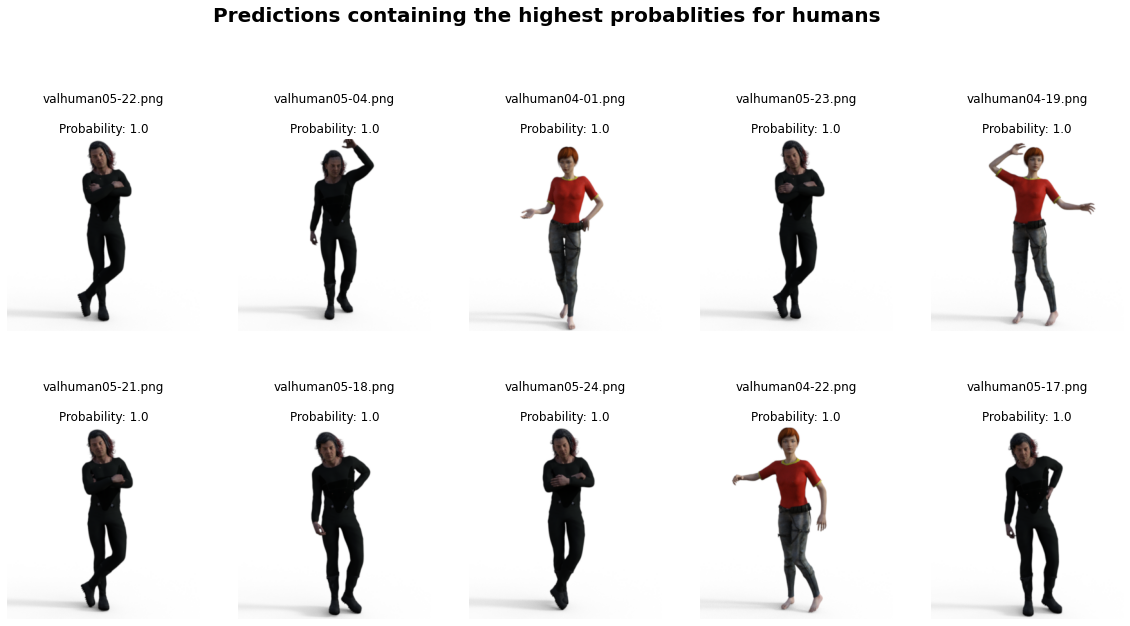

In [62]:
# Predictions containing the highest probablities for humans
indices = get_sorted_images_with_probabilities(prediction_table,
get_highest_probability=True, label=1, number_of_items=10,
only_false_predictions=False)
message = 'Predictions containing the highest probablities for humans'
display(indices[:10], message)

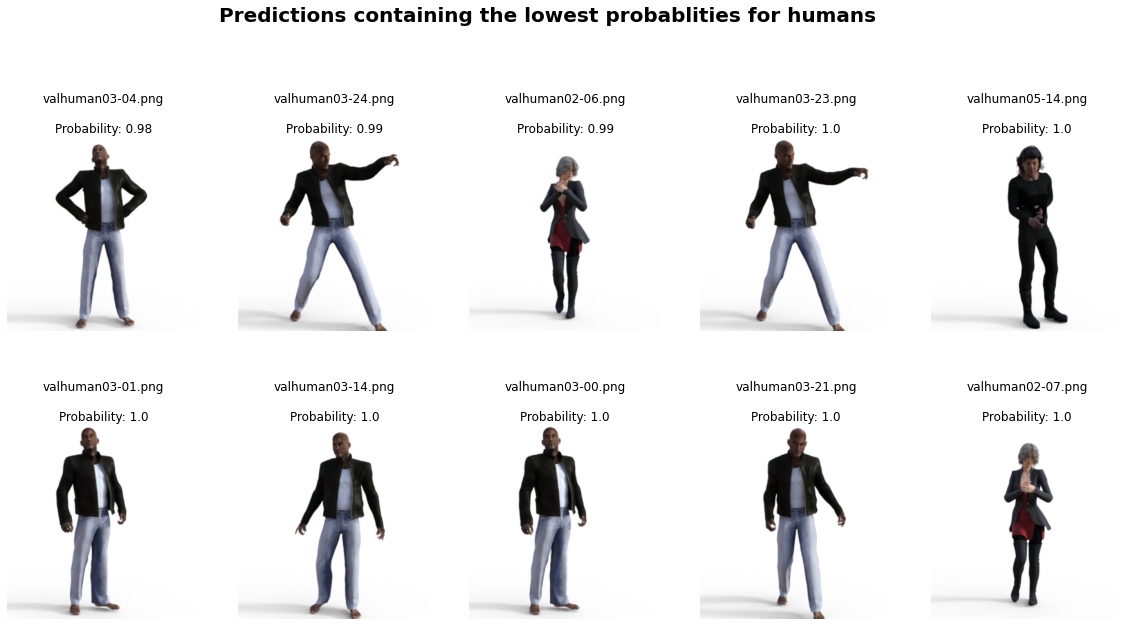

In [63]:
# Predictions containing the lowest probablities for humans
indices = get_sorted_images_with_probabilities(prediction_table,
get_highest_probability=False, label=1, number_of_items=10,
only_false_predictions=False)
message = 'Predictions containing the lowest probablities for humans'
display(indices[:10], message)